In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [159]:
files =  glob.glob("../dados_v5/*.dat")
print(len(files))
#files.extend(glob.glob("../dados_v5/*.dat"))

40


In [160]:
len(files)

40

In [161]:
files[0]

'../dados_v5/Co-57_41cm_1-0e08estories_0.dat'

In [162]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    try:
        return float(linhas[16400+7][1:])
    except:
        return float(linhas[16400+6][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [163]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 5.066599085648148 dias


In [164]:
energias_iniciais_multicanal = ['0', '1', '150', '250', '300', '400']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [165]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [166]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith('_' + energia_inicial_multicanal + '.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        n_particulas = float(partes[2].replace('estories','').replace('-','.'))
        dados_ = carrega_dados(file_, n_particulas)
        
        label_ = binarizer.transform([[nuclideo]])

        #Cria o label para o total de contagens do radionuclídeo
        total_counts = np.zeros(label_.shape)
        total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)
        
        dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({'X' : dados_.counts.values,
                                                                                 'n' : n_particulas,
                                                                                 'y': label_,
                                                                                 'y_count' : total_counts,
                                                                                 'd': distancia,
                                                                                 'e': energia_inicial_multicanal})

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [167]:
distancias = list(np.unique([x['d'] for x in dados_por_energia_inicial_multicanal[energias_iniciais_multicanal[0]]]))
n_particulas = list(np.unique([x['n'] for x in dados_por_energia_inicial_multicanal[energias_iniciais_multicanal[0]]]))
distancias, n_particulas

(['41cm', '46cm', '51cm', '56cm'], [100000000.0])

In [168]:
dados_por_energia_inicial_multicanal.keys()

dict_keys(['0', '1', '150', '250', '300', '400'])

In [169]:
a = 0
for k in dados_por_energia_inicial_multicanal:
    print(len(dados_por_energia_inicial_multicanal[k]))
    a += len(dados_por_energia_inicial_multicanal[k])
a

40
0
0
0
0
0


40

## Leituras experimentais da GRR

In [35]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [36]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [37]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [ ]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [38]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.0: #0.3
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

In [170]:
X = []
y = []
y_counts = []

## Com os dados experimentais

In [ ]:
"""
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    how_many_combinations = 500
    if n_combinacao == 1:
        how_many_combinations = 1320
    for i in range(how_many_combinations):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)
"""

# gerando imagens com mais de um espectro
#n_combinacoes = [2, 3, 4]
#for n_combinacao in n_combinacoes:
#    for i in range(500):
#        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
#        X.append(img)
#        y.append(label)
#        y_counts.append(counts)

In [40]:
len(X), len(y), len(y_counts)

(0, 0, 0)

## Com os dados gerados pelo PENELOPE

In [171]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['y_count'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels, counts

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [178]:
aux_data

[]

In [179]:
d_test = '56cm'
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for distancia in [x for x in distancias if x != d_test]:
            for n_particula in n_particulas:
                aux_data = [x for x in dados_por_energia_inicial_multicanal[key]
                            if x['d'] == distancia and x['n'] == n_particula]
                if len(aux_data) == 0:
                    continue
                for i in range(150):
                    values, labels, counts = gera_imagem_combinada_penelope(aux_data, n_)
                    novos_dados[key].append({'X' : values,
                                             'y': labels,
                                             'y_count': counts})

In [180]:
# Adiciona os espectros sem mistura
for key in energias_iniciais_multicanal:
    for item in [x for x in dados_por_energia_inicial_multicanal[key] if x['d'] != d_test]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [181]:
# Adiciona os espectros com mistura
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [182]:
len(X), len(y), len(y_counts)

(1380, 1380, 1380)

## Validação

In [183]:
X_test = []
y_test = []
y_counts_test = []

In [186]:
n_combinacoes = [1, 2, 3, 4]
novos_dados_test = dict()

for key in energias_iniciais_multicanal:
    novos_dados_test[key] = []
    for n_ in n_combinacoes:
        for distancia in [x for x in distancias if x == d_test]:
            for n_particula in n_particulas:
                aux_data = [x for x in dados_por_energia_inicial_multicanal[key]
                            if x['d'] == distancia and x['n'] == n_particula]
                if len(aux_data) == 0:
                    continue
            
                for i in range(25):
                    values, labels, counts = gera_imagem_combinada_penelope(aux_data, n_)
                    novos_dados_test[key].append({'X' : values,
                                             'y': labels,
                                             'y_count': counts})

In [187]:
for key in energias_iniciais_multicanal:
    for item in novos_dados_test[key]:
        X_test.append(list(item.values())[0].reshape((128, 128)))
        y_test.append(item['y'][0])
        y_counts_test.append(item['y_count'][0])

In [188]:
len(X_test), len(y_test), len(y_counts_test)

(100, 100, 100)

# Modelo

## Escalando os dados de contagem

A rede neural gosta de coisas entre -1 e 1 ...

In [189]:
scaler = StandardScaler()
scaler.fit(y_counts)

#X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, scaler.transform(y_counts))),
#                                                    test_size=0.30,
#                                                    random_state=42)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [190]:
X_all_train = X
X_all_test  = X_test

In [191]:
y_all_train = list(zip(y, scaler.transform(y_counts)))

In [192]:
y_all_test = list(zip(y_test, scaler.transform(y_counts_test)))

In [193]:
len(X_all_train), len(X_all_test), len(y_all_train), len(y_all_test)

(1380, 100, 1380, 100)

## Armazenando os dados originais

In [194]:
!mkdir dados_v5
#!rm -rf dados_v5

mkdir: cannot create directory ‘dados_v5’: File exists


In [195]:
np.save("./dados_v5/X.npy", [x.reshape((128,128,1)) for x in X])
np.save("./dados_v5/y.npy", y)
np.save("./dados_v5/y_counts.npy", y_counts)

In [196]:
np.save("./dados_v5/X_test.npy", [x.reshape((128,128,1)) for x in X_test])
np.save("./dados_v5/y_test.npy", y_test)
np.save("./dados_v5/y_counts_test.npy", y_counts_test)

In [197]:
from keras.utils import Sequence

In [198]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [199]:
s = EspectraSequence(X_all_train, [x[0] for x in y_all_train], [x[1] for x in y_all_train], batch_size=8)

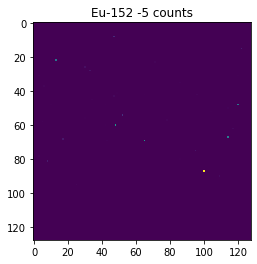

In [200]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(
    np.sum(c[0])))
plt.show()

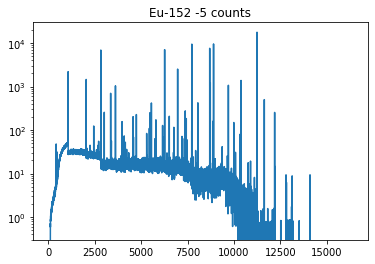

In [201]:
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.yscale("log")
plt.plot(a[0].reshape(-1))
plt.show()

In [202]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [203]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)

pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)

pred_counts = keras.layers.Dense(10, activation=None)(x1)

pred_counts = keras.layers.add([pred_counts, pred_nuclei], name="predictions_counts")

#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [204]:
learning_rate = 1e-3
epochs = 250
batch_size = 8
steps_per_epoch = len(X_all_train) // batch_size + 1
validation_steps = len(X_all_test) // batch_size + 1

In [205]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=opt,
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

In [ ]:
!nvidia-smi

In [206]:
!rm -rf ./logs_v5
!mkdir ./logs_v5

In [207]:
gerador_treino = EspectraSequence(X_all_train, [x[0] for x in y_all_train], [x[1] for x in y_all_train],
                                  batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_all_test, [x[0] for x in y_all_test], [x[1] for x in y_all_test],
                                     batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=50)

tb = keras.callbacks.TensorBoard(
    log_dir='./logs_v4',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb]

In [208]:
hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)

Epoch 1/250
 - 15s - loss: 2.8829 - predictions_nuclei_loss: 0.6617 - predictions_counts_loss: 2.2212 - predictions_nuclei_my_accuracy_score: 0.0000e+00 - predictions_nuclei_acc: 0.6622 - predictions_counts_mean_squared_error: 2.2212 - predictions_counts_mean_absolute_error: 1.0383 - val_loss: 1.3852 - val_predictions_nuclei_loss: 0.6584 - val_predictions_counts_loss: 0.7269 - val_predictions_nuclei_my_accuracy_score: 0.0000e+00 - val_predictions_nuclei_acc: 0.7500 - val_predictions_counts_mean_squared_error: 0.7269 - val_predictions_counts_mean_absolute_error: 0.8205
Epoch 2/250
 - 14s - loss: 1.3802 - predictions_nuclei_loss: 0.5581 - predictions_counts_loss: 0.8221 - predictions_nuclei_my_accuracy_score: 0.0000e+00 - predictions_nuclei_acc: 0.7712 - predictions_counts_mean_squared_error: 0.8221 - predictions_counts_mean_absolute_error: 0.7786 - val_loss: 1.0323 - val_predictions_nuclei_loss: 0.5068 - val_predictions_counts_loss: 0.5255 - val_predictions_nuclei_my_accuracy_score: 0.0

Epoch 16/250
 - 14s - loss: 0.4877 - predictions_nuclei_loss: 0.1871 - predictions_counts_loss: 0.3006 - predictions_nuclei_my_accuracy_score: 0.2608 - predictions_nuclei_acc: 0.9105 - predictions_counts_mean_squared_error: 0.3006 - predictions_counts_mean_absolute_error: 0.3156 - val_loss: 0.4275 - val_predictions_nuclei_loss: 0.2051 - val_predictions_counts_loss: 0.2224 - val_predictions_nuclei_my_accuracy_score: 0.3600 - val_predictions_nuclei_acc: 0.9020 - val_predictions_counts_mean_squared_error: 0.2224 - val_predictions_counts_mean_absolute_error: 0.3209
Epoch 17/250
 - 14s - loss: 0.4882 - predictions_nuclei_loss: 0.1865 - predictions_counts_loss: 0.3017 - predictions_nuclei_my_accuracy_score: 0.2536 - predictions_nuclei_acc: 0.9090 - predictions_counts_mean_squared_error: 0.3017 - predictions_counts_mean_absolute_error: 0.3191 - val_loss: 0.3870 - val_predictions_nuclei_loss: 0.1858 - val_predictions_counts_loss: 0.2012 - val_predictions_nuclei_my_accuracy_score: 0.3800 - val_

Epoch 31/250
 - 14s - loss: 0.4708 - predictions_nuclei_loss: 0.1801 - predictions_counts_loss: 0.2907 - predictions_nuclei_my_accuracy_score: 0.3006 - predictions_nuclei_acc: 0.9103 - predictions_counts_mean_squared_error: 0.2907 - predictions_counts_mean_absolute_error: 0.2993 - val_loss: 0.3526 - val_predictions_nuclei_loss: 0.1802 - val_predictions_counts_loss: 0.1724 - val_predictions_nuclei_my_accuracy_score: 0.3300 - val_predictions_nuclei_acc: 0.9340 - val_predictions_counts_mean_squared_error: 0.1724 - val_predictions_counts_mean_absolute_error: 0.2797
Epoch 32/250
 - 14s - loss: 0.4653 - predictions_nuclei_loss: 0.1762 - predictions_counts_loss: 0.2891 - predictions_nuclei_my_accuracy_score: 0.2991 - predictions_nuclei_acc: 0.9105 - predictions_counts_mean_squared_error: 0.2891 - predictions_counts_mean_absolute_error: 0.2988 - val_loss: 0.4157 - val_predictions_nuclei_loss: 0.1976 - val_predictions_counts_loss: 0.2181 - val_predictions_nuclei_my_accuracy_score: 0.3700 - val_

Epoch 46/250
 - 14s - loss: 0.4557 - predictions_nuclei_loss: 0.1738 - predictions_counts_loss: 0.2818 - predictions_nuclei_my_accuracy_score: 0.3006 - predictions_nuclei_acc: 0.9129 - predictions_counts_mean_squared_error: 0.2818 - predictions_counts_mean_absolute_error: 0.2918 - val_loss: 0.3706 - val_predictions_nuclei_loss: 0.1865 - val_predictions_counts_loss: 0.1841 - val_predictions_nuclei_my_accuracy_score: 0.4300 - val_predictions_nuclei_acc: 0.9010 - val_predictions_counts_mean_squared_error: 0.1841 - val_predictions_counts_mean_absolute_error: 0.2804
Epoch 47/250
 - 14s - loss: 0.4537 - predictions_nuclei_loss: 0.1731 - predictions_counts_loss: 0.2805 - predictions_nuclei_my_accuracy_score: 0.3013 - predictions_nuclei_acc: 0.9132 - predictions_counts_mean_squared_error: 0.2805 - predictions_counts_mean_absolute_error: 0.2900 - val_loss: 0.3858 - val_predictions_nuclei_loss: 0.2016 - val_predictions_counts_loss: 0.1842 - val_predictions_nuclei_my_accuracy_score: 0.1600 - val_

Epoch 61/250
 - 14s - loss: 0.3053 - predictions_nuclei_loss: 0.1164 - predictions_counts_loss: 0.1888 - predictions_nuclei_my_accuracy_score: 0.4256 - predictions_nuclei_acc: 0.9442 - predictions_counts_mean_squared_error: 0.1888 - predictions_counts_mean_absolute_error: 0.2232 - val_loss: 0.2518 - val_predictions_nuclei_loss: 0.1249 - val_predictions_counts_loss: 0.1269 - val_predictions_nuclei_my_accuracy_score: 0.4700 - val_predictions_nuclei_acc: 0.9370 - val_predictions_counts_mean_squared_error: 0.1269 - val_predictions_counts_mean_absolute_error: 0.2166
Epoch 62/250
 - 14s - loss: 0.3081 - predictions_nuclei_loss: 0.1154 - predictions_counts_loss: 0.1927 - predictions_nuclei_my_accuracy_score: 0.4400 - predictions_nuclei_acc: 0.9441 - predictions_counts_mean_squared_error: 0.1927 - predictions_counts_mean_absolute_error: 0.2285 - val_loss: 0.2482 - val_predictions_nuclei_loss: 0.1167 - val_predictions_counts_loss: 0.1315 - val_predictions_nuclei_my_accuracy_score: 0.5000 - val_

Epoch 76/250
 - 14s - loss: 0.1954 - predictions_nuclei_loss: 0.0754 - predictions_counts_loss: 0.1200 - predictions_nuclei_my_accuracy_score: 0.5658 - predictions_nuclei_acc: 0.9644 - predictions_counts_mean_squared_error: 0.1200 - predictions_counts_mean_absolute_error: 0.1664 - val_loss: 0.1799 - val_predictions_nuclei_loss: 0.0892 - val_predictions_counts_loss: 0.0907 - val_predictions_nuclei_my_accuracy_score: 0.6000 - val_predictions_nuclei_acc: 0.9510 - val_predictions_counts_mean_squared_error: 0.0907 - val_predictions_counts_mean_absolute_error: 0.1634
Epoch 77/250
 - 14s - loss: 0.1957 - predictions_nuclei_loss: 0.0748 - predictions_counts_loss: 0.1209 - predictions_nuclei_my_accuracy_score: 0.5679 - predictions_nuclei_acc: 0.9653 - predictions_counts_mean_squared_error: 0.1209 - predictions_counts_mean_absolute_error: 0.1703 - val_loss: 0.1790 - val_predictions_nuclei_loss: 0.0872 - val_predictions_counts_loss: 0.0919 - val_predictions_nuclei_my_accuracy_score: 0.5400 - val_

Epoch 91/250
 - 14s - loss: 0.1835 - predictions_nuclei_loss: 0.0711 - predictions_counts_loss: 0.1124 - predictions_nuclei_my_accuracy_score: 0.6084 - predictions_nuclei_acc: 0.9659 - predictions_counts_mean_squared_error: 0.1124 - predictions_counts_mean_absolute_error: 0.1540 - val_loss: 0.1733 - val_predictions_nuclei_loss: 0.0913 - val_predictions_counts_loss: 0.0820 - val_predictions_nuclei_my_accuracy_score: 0.5000 - val_predictions_nuclei_acc: 0.9480 - val_predictions_counts_mean_squared_error: 0.0820 - val_predictions_counts_mean_absolute_error: 0.1409
Epoch 92/250
 - 14s - loss: 0.1804 - predictions_nuclei_loss: 0.0690 - predictions_counts_loss: 0.1114 - predictions_nuclei_my_accuracy_score: 0.6200 - predictions_nuclei_acc: 0.9674 - predictions_counts_mean_squared_error: 0.1114 - predictions_counts_mean_absolute_error: 0.1549 - val_loss: 0.1616 - val_predictions_nuclei_loss: 0.0855 - val_predictions_counts_loss: 0.0761 - val_predictions_nuclei_my_accuracy_score: 0.4700 - val_

Epoch 106/250
 - 14s - loss: 0.1787 - predictions_nuclei_loss: 0.0685 - predictions_counts_loss: 0.1102 - predictions_nuclei_my_accuracy_score: 0.6308 - predictions_nuclei_acc: 0.9674 - predictions_counts_mean_squared_error: 0.1102 - predictions_counts_mean_absolute_error: 0.1476 - val_loss: 0.1610 - val_predictions_nuclei_loss: 0.0848 - val_predictions_counts_loss: 0.0762 - val_predictions_nuclei_my_accuracy_score: 0.6500 - val_predictions_nuclei_acc: 0.9530 - val_predictions_counts_mean_squared_error: 0.0762 - val_predictions_counts_mean_absolute_error: 0.1363
Epoch 107/250
 - 14s - loss: 0.1710 - predictions_nuclei_loss: 0.0666 - predictions_counts_loss: 0.1045 - predictions_nuclei_my_accuracy_score: 0.6337 - predictions_nuclei_acc: 0.9669 - predictions_counts_mean_squared_error: 0.1045 - predictions_counts_mean_absolute_error: 0.1393 - val_loss: 0.1615 - val_predictions_nuclei_loss: 0.0746 - val_predictions_counts_loss: 0.0869 - val_predictions_nuclei_my_accuracy_score: 0.7000 - va

Epoch 121/250
 - 14s - loss: 0.1373 - predictions_nuclei_loss: 0.0532 - predictions_counts_loss: 0.0841 - predictions_nuclei_my_accuracy_score: 0.6734 - predictions_nuclei_acc: 0.9738 - predictions_counts_mean_squared_error: 0.0841 - predictions_counts_mean_absolute_error: 0.1262 - val_loss: 0.1335 - val_predictions_nuclei_loss: 0.0645 - val_predictions_counts_loss: 0.0690 - val_predictions_nuclei_my_accuracy_score: 0.7300 - val_predictions_nuclei_acc: 0.9660 - val_predictions_counts_mean_squared_error: 0.0690 - val_predictions_counts_mean_absolute_error: 0.1392
Epoch 122/250
 - 14s - loss: 0.1329 - predictions_nuclei_loss: 0.0517 - predictions_counts_loss: 0.0811 - predictions_nuclei_my_accuracy_score: 0.6756 - predictions_nuclei_acc: 0.9735 - predictions_counts_mean_squared_error: 0.0811 - predictions_counts_mean_absolute_error: 0.1197 - val_loss: 0.1306 - val_predictions_nuclei_loss: 0.0696 - val_predictions_counts_loss: 0.0609 - val_predictions_nuclei_my_accuracy_score: 0.5700 - va

Epoch 136/250
 - 14s - loss: 0.0116 - predictions_nuclei_loss: 0.0022 - predictions_counts_loss: 0.0094 - predictions_nuclei_my_accuracy_score: 0.9422 - predictions_nuclei_acc: 0.9999 - predictions_counts_mean_squared_error: 0.0094 - predictions_counts_mean_absolute_error: 0.0621 - val_loss: 0.0337 - val_predictions_nuclei_loss: 0.0111 - val_predictions_counts_loss: 0.0226 - val_predictions_nuclei_my_accuracy_score: 0.7800 - val_predictions_nuclei_acc: 0.9950 - val_predictions_counts_mean_squared_error: 0.0226 - val_predictions_counts_mean_absolute_error: 0.0931
Epoch 137/250
 - 14s - loss: 0.0099 - predictions_nuclei_loss: 0.0018 - predictions_counts_loss: 0.0081 - predictions_nuclei_my_accuracy_score: 0.9523 - predictions_nuclei_acc: 0.9999 - predictions_counts_mean_squared_error: 0.0081 - predictions_counts_mean_absolute_error: 0.0582 - val_loss: 0.0276 - val_predictions_nuclei_loss: 0.0098 - val_predictions_counts_loss: 0.0178 - val_predictions_nuclei_my_accuracy_score: 0.8100 - va

Epoch 151/250
 - 14s - loss: 0.0038 - predictions_nuclei_loss: 3.1812e-04 - predictions_counts_loss: 0.0035 - predictions_nuclei_my_accuracy_score: 0.9978 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0035 - predictions_counts_mean_absolute_error: 0.0375 - val_loss: 0.0223 - val_predictions_nuclei_loss: 0.0054 - val_predictions_counts_loss: 0.0169 - val_predictions_nuclei_my_accuracy_score: 0.9400 - val_predictions_nuclei_acc: 0.9960 - val_predictions_counts_mean_squared_error: 0.0169 - val_predictions_counts_mean_absolute_error: 0.0790
Epoch 152/250
 - 14s - loss: 0.0037 - predictions_nuclei_loss: 2.7825e-04 - predictions_counts_loss: 0.0034 - predictions_nuclei_my_accuracy_score: 0.9993 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0034 - predictions_counts_mean_absolute_error: 0.0364 - val_loss: 0.0200 - val_predictions_nuclei_loss: 0.0061 - val_predictions_counts_loss: 0.0139 - val_predictions_nuclei_my_accuracy_score: 0.9

Epoch 166/250
 - 14s - loss: 0.0027 - predictions_nuclei_loss: 1.7054e-04 - predictions_counts_loss: 0.0025 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0025 - predictions_counts_mean_absolute_error: 0.0311 - val_loss: 0.0162 - val_predictions_nuclei_loss: 0.0055 - val_predictions_counts_loss: 0.0107 - val_predictions_nuclei_my_accuracy_score: 0.9600 - val_predictions_nuclei_acc: 0.9960 - val_predictions_counts_mean_squared_error: 0.0107 - val_predictions_counts_mean_absolute_error: 0.0647
Epoch 167/250
 - 14s - loss: 0.0025 - predictions_nuclei_loss: 1.6386e-04 - predictions_counts_loss: 0.0023 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0023 - predictions_counts_mean_absolute_error: 0.0299 - val_loss: 0.0164 - val_predictions_nuclei_loss: 0.0056 - val_predictions_counts_loss: 0.0109 - val_predictions_nuclei_my_accuracy_score: 0.9

Epoch 181/250
 - 14s - loss: 0.0018 - predictions_nuclei_loss: 1.1549e-04 - predictions_counts_loss: 0.0017 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0017 - predictions_counts_mean_absolute_error: 0.0256 - val_loss: 0.0161 - val_predictions_nuclei_loss: 0.0050 - val_predictions_counts_loss: 0.0111 - val_predictions_nuclei_my_accuracy_score: 0.9600 - val_predictions_nuclei_acc: 0.9970 - val_predictions_counts_mean_squared_error: 0.0111 - val_predictions_counts_mean_absolute_error: 0.0647
Epoch 182/250
 - 14s - loss: 0.0017 - predictions_nuclei_loss: 1.1315e-04 - predictions_counts_loss: 0.0016 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0016 - predictions_counts_mean_absolute_error: 0.0249 - val_loss: 0.0152 - val_predictions_nuclei_loss: 0.0045 - val_predictions_counts_loss: 0.0107 - val_predictions_nuclei_my_accuracy_score: 0.9

Epoch 196/250
 - 14s - loss: 0.0013 - predictions_nuclei_loss: 8.4085e-05 - predictions_counts_loss: 0.0012 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0012 - predictions_counts_mean_absolute_error: 0.0212 - val_loss: 0.0127 - val_predictions_nuclei_loss: 0.0033 - val_predictions_counts_loss: 0.0093 - val_predictions_nuclei_my_accuracy_score: 0.9800 - val_predictions_nuclei_acc: 1.0000 - val_predictions_counts_mean_squared_error: 0.0093 - val_predictions_counts_mean_absolute_error: 0.0594
Epoch 197/250
 - 14s - loss: 0.0012 - predictions_nuclei_loss: 8.3692e-05 - predictions_counts_loss: 0.0011 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 0.0011 - predictions_counts_mean_absolute_error: 0.0211 - val_loss: 0.0139 - val_predictions_nuclei_loss: 0.0043 - val_predictions_counts_loss: 0.0095 - val_predictions_nuclei_my_accuracy_score: 0.9

Epoch 211/250
 - 14s - loss: 8.8812e-04 - predictions_nuclei_loss: 6.5267e-05 - predictions_counts_loss: 8.2285e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 8.2285e-04 - predictions_counts_mean_absolute_error: 0.0174 - val_loss: 0.0123 - val_predictions_nuclei_loss: 0.0029 - val_predictions_counts_loss: 0.0095 - val_predictions_nuclei_my_accuracy_score: 0.9900 - val_predictions_nuclei_acc: 1.0000 - val_predictions_counts_mean_squared_error: 0.0095 - val_predictions_counts_mean_absolute_error: 0.0607
Epoch 212/250
 - 14s - loss: 9.9336e-04 - predictions_nuclei_loss: 6.7394e-05 - predictions_counts_loss: 9.2597e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 9.2597e-04 - predictions_counts_mean_absolute_error: 0.0193 - val_loss: 0.0124 - val_predictions_nuclei_loss: 0.0041 - val_predictions_counts_loss: 0.0083 - val_predictions_nucle

 - 14s - loss: 8.1250e-04 - predictions_nuclei_loss: 5.4621e-05 - predictions_counts_loss: 7.5788e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 7.5788e-04 - predictions_counts_mean_absolute_error: 0.0170 - val_loss: 0.0119 - val_predictions_nuclei_loss: 0.0035 - val_predictions_counts_loss: 0.0084 - val_predictions_nuclei_my_accuracy_score: 0.9800 - val_predictions_nuclei_acc: 1.0000 - val_predictions_counts_mean_squared_error: 0.0084 - val_predictions_counts_mean_absolute_error: 0.0575
Epoch 226/250
 - 14s - loss: 7.1912e-04 - predictions_nuclei_loss: 5.3229e-05 - predictions_counts_loss: 6.6589e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 6.6589e-04 - predictions_counts_mean_absolute_error: 0.0160 - val_loss: 0.0118 - val_predictions_nuclei_loss: 0.0040 - val_predictions_counts_loss: 0.0078 - val_predictions_nuclei_my_accuracy_

Epoch 240/250
 - 14s - loss: 5.7449e-04 - predictions_nuclei_loss: 4.3424e-05 - predictions_counts_loss: 5.3107e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 5.3107e-04 - predictions_counts_mean_absolute_error: 0.0142 - val_loss: 0.0122 - val_predictions_nuclei_loss: 0.0040 - val_predictions_counts_loss: 0.0082 - val_predictions_nuclei_my_accuracy_score: 0.9800 - val_predictions_nuclei_acc: 0.9970 - val_predictions_counts_mean_squared_error: 0.0082 - val_predictions_counts_mean_absolute_error: 0.0565
Epoch 241/250
 - 14s - loss: 5.4284e-04 - predictions_nuclei_loss: 4.3070e-05 - predictions_counts_loss: 4.9977e-04 - predictions_nuclei_my_accuracy_score: 1.0000 - predictions_nuclei_acc: 1.0000 - predictions_counts_mean_squared_error: 4.9977e-04 - predictions_counts_mean_absolute_error: 0.0138 - val_loss: 0.0114 - val_predictions_nuclei_loss: 0.0037 - val_predictions_counts_loss: 0.0077 - val_predictions_nucle

In [114]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-classificacao-regressao-PENELOPE-v5.hdf5')

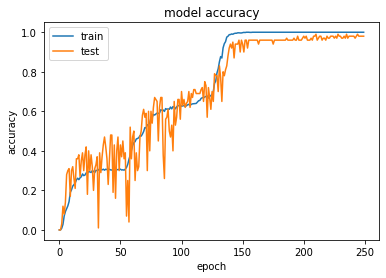

In [209]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

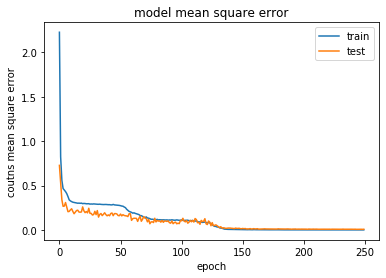

In [210]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model mean square error')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

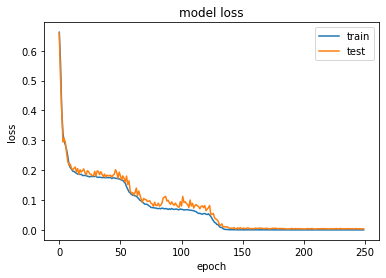

In [211]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [212]:
val_metrics = model.evaluate_generator(gerador_validacao,
                                       steps=validation_steps,
                                      verbose=1)
train_metrics = model.evaluate_generator(gerador_treino,
                                         steps=steps_per_epoch,
                                        verbose=1)


173/173 [==============================] - 4s 23ms/step


In [213]:
list(zip(model.metrics_names, val_metrics))

[('loss', 0.011672768238931895),
 ('predictions_nuclei_loss', 0.0035730783420149237),
 ('predictions_counts_loss', 0.008099689856171608),
 ('predictions_nuclei_my_accuracy_score', 0.98),
 ('predictions_nuclei_acc', 0.997000002861023),
 ('predictions_counts_mean_squared_error', 0.008099689856171608),
 ('predictions_counts_mean_absolute_error', 0.05565500974655151)]

In [214]:
list(zip(model.metrics_names, train_metrics))

[('loss', 0.0007374735336507792),
 ('predictions_nuclei_loss', 3.8743987538246204e-05),
 ('predictions_counts_loss', 0.0006987295463593488),
 ('predictions_nuclei_my_accuracy_score', 1.0),
 ('predictions_nuclei_acc', 1.0),
 ('predictions_counts_mean_squared_error', 0.0006987295463593488),
 ('predictions_counts_mean_absolute_error', 0.016177087763081428)]

# Validando nos espectros criados com Penelope

In [120]:
from keras.utils.vis_utils import plot_model

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

2


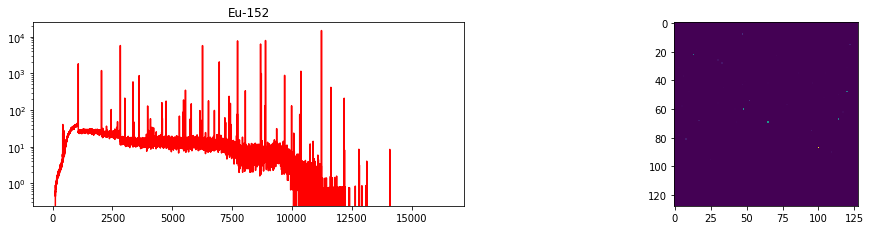

In [215]:
idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[idx].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

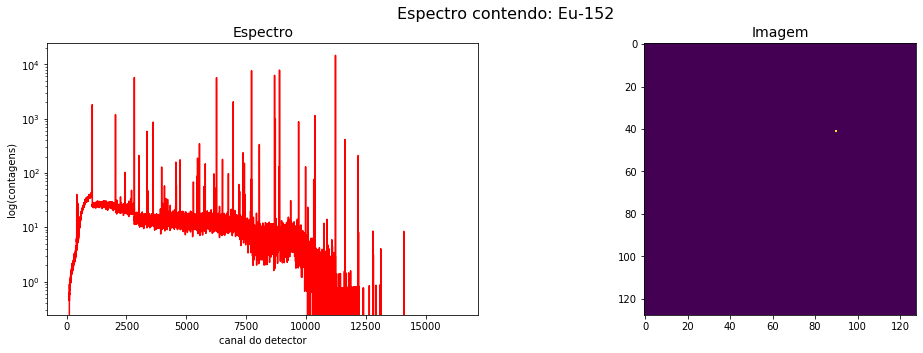

In [216]:
"""
f, axarr = plt.subplots(1, 2, figsize=(17, 5))
plt.suptitle("Fonte tríplice de calibração Am-214, Cs-137, Co-60", fontsize=16)
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro")
axarr[0].set_yscale("log")

axarr[1].imshow(np.array(dados).reshape((128,128)))
axarr[1].set_title("Imagem")
axarr[1].grid(False)

#plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()
"""
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']


f, axarr = plt.subplots(1, 2, figsize=(17, 5))
plt.suptitle("Espectro contendo: "+" e ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]),
             fontsize=16)


axarr[0].plot(range(len(x_[idx].reshape(-1))), x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")
axarr[0].set_xlabel("canal do detector")
axarr[0].set_ylabel("log(contagens)")
axarr[0].set_title("Espectro", fontsize=14)

axarr[1].set_title("Imagem", fontsize=14)
axarr[1].imshow(x_[0].reshape((128,128)))

#plt.grid(False)
#plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [217]:
%time
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 36.2 µs


In [218]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': scaler.inverse_transform(y_counts[idx])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-8.41,0.00
1,Ba-133,0.01,-438.08,0.00
2,Cd-109,0.00,-1.34,0.00
3,Co-57,0.00,-117.83,0.00
4,Co-60,0.02,"-9,958.37",-0.00
5,Cs-137,0.01,"-2,831.42",0.00
6,Eu-152,99.99,"219,831.75","201,280.95"
7,Mn-54,0.05,"4,771.39",0.00
8,Na-22,0.01,"-6,987.68",0.00
9,Pb-210,0.00,-0.20,0.00


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [219]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [220]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


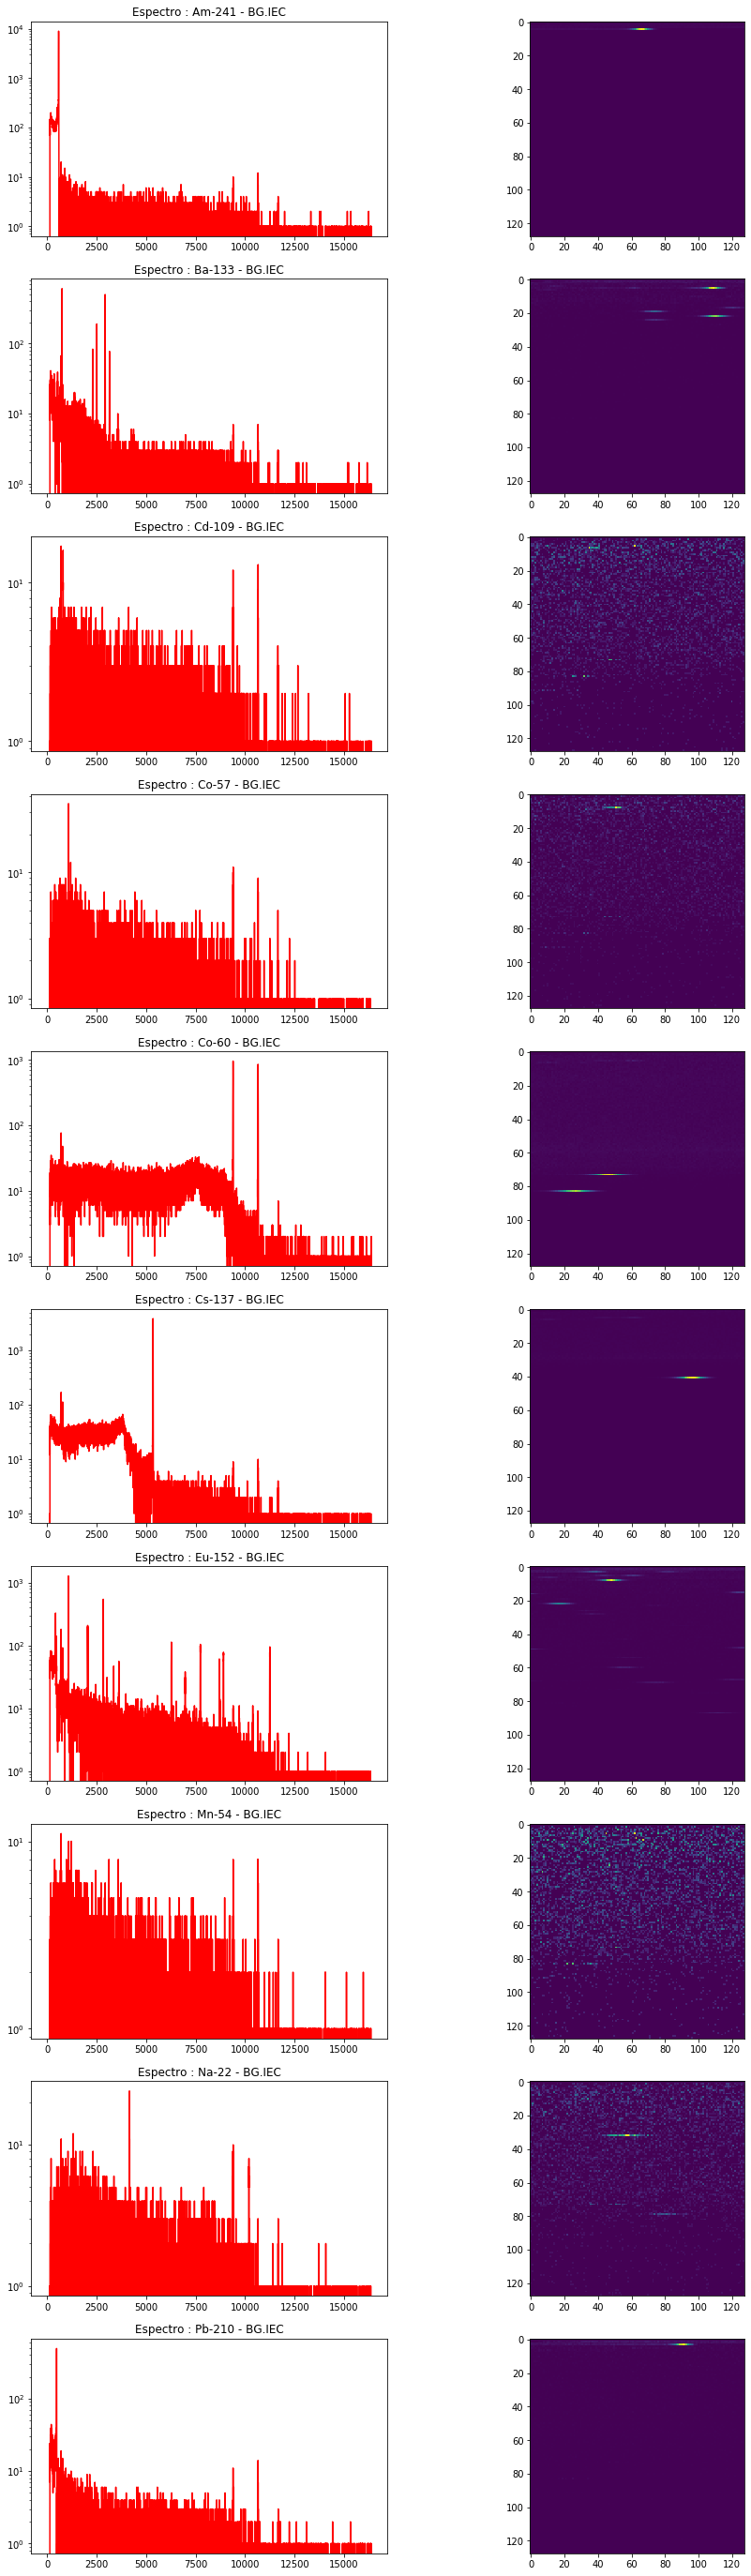

In [128]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    axarr[n, 0].set_yscale("log")
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [221]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"2,640.46","141,596.00"
1,Ba-133,0.00,"-1,776.16","141,596.00"
2,Cd-109,78.36,237.03,"141,596.00"
3,Co-57,0.19,"4,574.97","141,596.00"
4,Co-60,0.00,"26,482.94","141,596.00"
5,Cs-137,0.00,"1,420.45","141,596.00"
6,Eu-152,0.00,"11,946.21","141,596.00"
7,Mn-54,0.00,"-11,664.65","141,596.00"
8,Na-22,0.00,"-21,709.38","141,596.00"
9,Pb-210,97.12,50.72,"141,596.00"


In [222]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.96,"1,276.87","35,319.00"
1,Ba-133,0.00,"2,296.14","35,319.00"
2,Cd-109,100.00,459.77,"35,319.00"
3,Co-57,0.00,"3,535.57","35,319.00"
4,Co-60,0.00,"-3,802.23","35,319.00"
5,Cs-137,0.00,"-2,244.56","35,319.00"
6,Eu-152,0.00,"3,184.95","35,319.00"
7,Mn-54,0.00,"7,492.76","35,319.00"
8,Na-22,0.00,-134.48,"35,319.00"
9,Pb-210,100.00,77.82,"35,319.00"


In [223]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-7.40,"7,195.00"
1,Ba-133,0.00,313.56,"7,195.00"
2,Cd-109,0.00,2.75,"7,195.00"
3,Co-57,0.00,317.07,"7,195.00"
4,Co-60,0.00,"10,245.58","7,195.00"
5,Cs-137,0.00,"1,540.18","7,195.00"
6,Eu-152,0.00,"-3,254.38","7,195.00"
7,Mn-54,0.00,"3,222.91","7,195.00"
8,Na-22,0.00,"13,713.79","7,195.00"
9,Pb-210,10.30,10.88,"7,195.00"


In [224]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-1.58,"7,323.00"
1,Ba-133,0.00,382.92,"7,323.00"
2,Cd-109,0.00,3.45,"7,323.00"
3,Co-57,0.00,294.49,"7,323.00"
4,Co-60,0.00,"10,321.39","7,323.00"
5,Cs-137,0.00,"1,616.93","7,323.00"
6,Eu-152,0.00,"-3,305.24","7,323.00"
7,Mn-54,0.00,"3,168.04","7,323.00"
8,Na-22,0.00,"13,763.87","7,323.00"
9,Pb-210,8.51,9.96,"7,323.00"


In [225]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.88,"1,552.01","155,643.00"
1,Ba-133,0.00,"-1,610.22","155,643.00"
2,Cd-109,100.00,482.94,"155,643.00"
3,Co-57,0.00,700.87,"155,643.00"
4,Co-60,0.00,"-68,734.31","155,643.00"
5,Cs-137,0.00,"1,239.89","155,643.00"
6,Eu-152,0.00,"2,930.41","155,643.00"
7,Mn-54,0.00,"-12,110.82","155,643.00"
8,Na-22,0.00,"-18,264.38","155,643.00"
9,Pb-210,99.91,56.53,"155,643.00"


In [226]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"1,960.42","188,461.00"
1,Ba-133,0.00,"1,109.47","188,461.00"
2,Cd-109,99.48,330.32,"188,461.00"
3,Co-57,0.00,"3,078.06","188,461.00"
4,Co-60,0.00,"5,224.59","188,461.00"
5,Cs-137,0.00,"-6,412.73","188,461.00"
6,Eu-152,0.00,"9,314.96","188,461.00"
7,Mn-54,0.00,"29,165.49","188,461.00"
8,Na-22,0.00,"72,900.98","188,461.00"
9,Pb-210,99.99,58.02,"188,461.00"


In [227]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,89.37,"1,222.71","94,419.00"
1,Ba-133,0.00,-234.71,"94,419.00"
2,Cd-109,100.00,587.75,"94,419.00"
3,Co-57,0.00,"5,065.22","94,419.00"
4,Co-60,0.00,"16,460.96","94,419.00"
5,Cs-137,0.00,"-4,420.80","94,419.00"
6,Eu-152,0.00,"-9,402.40","94,419.00"
7,Mn-54,0.00,"16,052.39","94,419.00"
8,Na-22,0.00,"20,668.13","94,419.00"
9,Pb-210,100.00,66.66,"94,419.00"


In [228]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-3.57,"7,159.00"
1,Ba-133,0.00,329.99,"7,159.00"
2,Cd-109,0.00,1.94,"7,159.00"
3,Co-57,0.00,298.76,"7,159.00"
4,Co-60,0.00,"10,106.33","7,159.00"
5,Cs-137,0.00,"1,594.40","7,159.00"
6,Eu-152,0.00,"-3,210.27","7,159.00"
7,Mn-54,0.00,"3,097.75","7,159.00"
8,Na-22,0.00,"13,431.68","7,159.00"
9,Pb-210,8.98,10.31,"7,159.00"


In [229]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,3.57,"7,965.00"
1,Ba-133,0.00,811.70,"7,965.00"
2,Cd-109,0.01,6.82,"7,965.00"
3,Co-57,0.00,222.98,"7,965.00"
4,Co-60,0.00,"11,193.09","7,965.00"
5,Cs-137,0.00,"1,403.25","7,965.00"
6,Eu-152,0.00,"-3,801.38","7,965.00"
7,Mn-54,0.00,"3,456.21","7,965.00"
8,Na-22,0.00,"15,406.99","7,965.00"
9,Pb-210,8.34,9.54,"7,965.00"


In [230]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-95.88,"19,650.00"
1,Ba-133,0.00,168.67,"19,650.00"
2,Cd-109,0.01,28.34,"19,650.00"
3,Co-57,0.00,561.57,"19,650.00"
4,Co-60,0.00,"7,567.99","19,650.00"
5,Cs-137,0.00,-595.61,"19,650.00"
6,Eu-152,0.00,"-6,837.40","19,650.00"
7,Mn-54,0.00,"4,114.57","19,650.00"
8,Na-22,0.00,"1,060.13","19,650.00"
9,Pb-210,100.00,62.46,"19,650.00"


## Fonte triplice de calibração

In [231]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

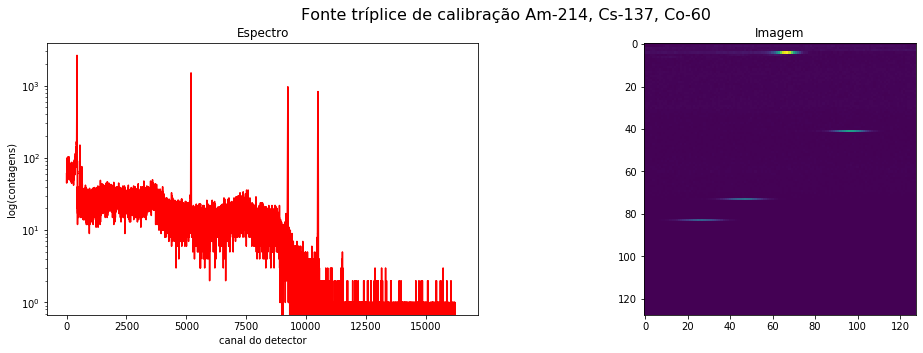

In [232]:
f, axarr = plt.subplots(1, 2, figsize=(17, 5))
plt.suptitle("Fonte tríplice de calibração Am-214, Cs-137, Co-60", fontsize=16)
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro")
axarr[0].set_yscale("log")
axarr[0].set_xlabel("canal do detector")
axarr[0].set_ylabel("log(contagens)")
axarr[1].imshow(np.array(dados).reshape((128,128)))
axarr[1].set_title("Imagem")
axarr[1].grid(False)

#plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [233]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

In [234]:
%time
preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

CPU times: user 16 µs, sys: 3 µs, total: 19 µs
Wall time: 37.2 µs


In [235]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"2,185.25","276,428.00"
1,Ba-133,0.00,"-3,429.11","276,428.00"
2,Cd-109,99.12,280.52,"276,428.00"
3,Co-57,0.02,"1,061.44","276,428.00"
4,Co-60,0.00,"7,227.27","276,428.00"
5,Cs-137,0.00,-402.28,"276,428.00"
6,Eu-152,0.00,"-1,379.58","276,428.00"
7,Mn-54,0.00,"-16,053.68","276,428.00"
8,Na-22,0.00,"5,183.30","276,428.00"
9,Pb-210,98.67,48.48,"276,428.00"


## Identificando os picos da fonte triplice para calcular a atividade por nuclídeo

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
import scipy
import peakutils

In [ ]:
from scipy.signal import find_peaks

In [ ]:
peaks, _ = find_peaks(df_triplice['counts'], prominence=2e2)
plt.plot(df_triplice['counts'])
plt.plot(peaks, df_triplice['counts'][peaks], "x")
plt.plot(np.zeros_like(df_triplice['counts']), "--", color="gray")
plt.show()

In [ ]:
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    values.append(np.trapz(df_triplice['counts'][peak-(1+1*idx):peak+(1+1*idx)], dx=15))
values, np.sum(values)

In [ ]:
values[-1] + values[-2], values[-1], values[-2]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
y_pred = scaler.transform([[36408, 0, 0, 0, 229988, 69041, 0, 0, 0, 0]])
y_     = scaler.transform([[52020, 0, 0, 0, 86410, 368790, 0, 0, 0, 0]])

y_pred = [[36408, 0, 0, 0, 229988, 69041, 0, 0, 0, 0]]
y_     = [[52020, 0, 0, 0, 86410, 368790, 0, 0, 0, 0]]

In [ ]:
np.sum(y_) / 1e6, np.sum(y_pred) / 1e6

In [ ]:
mean_squared_error(y_, y_pred, multioutput='uniform_average') / 1e6

In [ ]:
mean_absolute_error(y_, y_pred, multioutput='uniform_average')